<a href="https://colab.research.google.com/github/vpozdnyakov/YandexDiskExchangeXML/blob/master/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задача коммивояжера

Необходимо найти кратчайший маршрут из точки $1$, который проходит через все другие точки по одному разу и возвращается в $1$.

На вход подается текстовый файл из $n$ строк, где каждая строка содержит $n$ чисел, разделенных пробелами. Номер строки и номер числа обозначают точки, а само число — длину пути. Длина путь из точки в эту же точку обозначается нулем. Длина пути из точки $i$ в точку $j$ равна длине пути из точки $j$ в точку $i$

Пример такого файла:

```0  12 10 19 8
12 0  3  7  2
10 3  0  6  20
19 7  6  0  4
8  2  20 4  0```

Источник https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html, датасет FIVE

In [0]:
target_url = 'https://people.sc.fsu.edu/~jburkardt/datasets/tsp/five_d.txt'

Обозначим

$с_{ij}$ - длина пути из точки $i$ в точку $j$, а вектор $c^T = (c_{11}, c_{12}, \dots , c_{(n)(n-1)}, c_{(n)(n)})$

Переменная $x_{ij}$ принимает значение $1$ если маршрут содержит путь из точки $i$ в точку $j$, $0$ в противном случае

Переменная $u_{i}$ принимает порядковый номер следования точки $i$ в маршруте

Вектор $x^T = (x_{11}, x_{12}, \dots , x_{(n)(n-1)}, x_{(n)(n)}, u_1, u_2, \dots , u_n)$

Решаем задачу оптимизации

$\min c^Tx$

$\forall j: \sum_{i}{x_{ij} = 1}$

$\forall i: \sum_{j}{x_{ij} = 1}$

$\forall i \in [1, n], \forall j \in [2, n]: u_i - u_j + nx_{ij} \leq n-1$ ограничение на связность

In [0]:
import numpy as np
import cvxpy as cp
import pandas as pd
import urllib
import networkx as nx
from matplotlib import pyplot as plt

In [0]:
c = []
for line in urllib.request.urlopen(target_url):
    data = list(map(float, line.split()))
    if data:
        n = len(data)
    c.extend(data)
c.extend([1] * n)

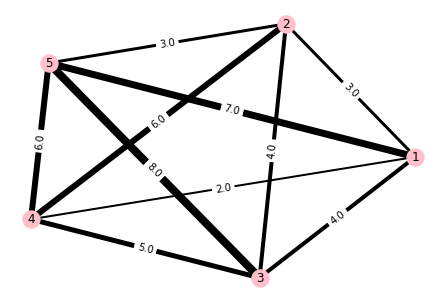

In [5]:
G = nx.Graph()

for i in range(n):
    for j in range(n):
        if i == j: continue
        G.add_edge(i+1, j+1)

pos = nx.spring_layout(G)
plt.figure()    

edge_labels = dict()
shift = 1
for i in range(n-1):
    for j in range(shift, n):
        edge_labels[(i+1, j+1)] = c[n*i + j]
        G[i+1][j+1]['weight'] = c[n*i + j]
    shift += 1

weights = [G[i][j]['weight'] for i,j in G.edges()]
nx.draw(G, pos, node_color='pink', width=weights)    
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.show()

Составим матрицы $A_1$, $A_2$ и векторы $b_1$ и $b_2$ таким образом, чтобы ограничения можно было переписать в виде:

$\left( \begin{matrix}
    \forall j: \sum_{i}{x_{ij} = 1} \\
    \forall i: \sum_{j}{x_{ij} = 1} \\
    \forall i \in [1, n], \forall j \in [2, n]: u_i - u_j + nx_{ij} \leq n-1
\end{matrix}\right)
\Rightarrow\left(\begin{matrix} 
    A_1x = b_1 \\
    A_2x \leq b_2
\end{matrix}\right)$

В коде $A_1$ и $A_2$, а так же $b_1$ и $b_2$ объединены.

In [0]:
A = np.zeros((2*n + n*(n-1), n*n + n), dtype=int)

for i in range(n):
    for j in range(i * n, (i+1) * n):
        A[i][j] = 1
        
shift = 0
for i in range(n, 2 * n):
    for j in range(shift, n * n, n):
        A[i][j] = 1
    shift += 1

shift = 0
for i in range(n * (n-1)):

    if (i+(n-1)) % (n-1) == 0:
        shift += 1
        
    A[2*n + i][i + shift] = n
    
    A[2*n + i][(n*n) + (i // (n-1)) ] = 1
    A[2*n + i][(n*n) + (i %  (n-1)) + 1] -= 1

In [7]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

columns = []
for i in range(n*n):
    columns.append('$x_{' + str(i//n + 1) + str(i%n + 1) + '}$')

for i in range(n):
    columns.append('$u_' + str(i + 1) + '$')

pd.DataFrame(A, columns=columns)

,$x_{11}$,$x_{12}$,$x_{13}$,$x_{14}$,$x_{15}$,$x_{21}$,$x_{22}$,$x_{23}$,$x_{24}$,$x_{25}$,$x_{31}$,$x_{32}$,$x_{33}$,$x_{34}$,$x_{35}$,$x_{41}$,$x_{42}$,$x_{43}$,$x_{44}$,$x_{45}$,$x_{51}$,$x_{52}$,$x_{53}$,$x_{54}$,$x_{55}$,$u_1$,$u_2$,$u_3$,$u_4$,$u_5$
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [0]:
x = cp.Variable(shape=(n*n + n), integer=True)
b = [1]*2*n + [n-1]*n*(n-1)
obj = c @ x
constraints = [
    (A[:2*n] @ x == b[:2*n]),
    (A[2*n:] @ x <= b[2*n:]),
    (x >= 0)
]

In [9]:
prob = cp.Problem(cp.Minimize(obj), constraints=constraints)
prob.solve(solver=cp.GLPK_MI)
prob.status

'optimal'

In [10]:
route = list(x.value[-n:].round())
for i in range(n):
    print(route.index(i) + 1, end=' → ')
print(route.index(0) + 1, end=' = ')
print(round(c[:n*n] @ x.value[:n*n]))

1 → 4 → 5 → 2 → 3 → 1 = 19.0
